In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
from astropy.io import fits

# Structure to store the outputs of fiber assignement

This notebook follows the documentation in DocDB-1049.

The principal outputs of Fiber Allocations are
- FiberMap. A pointing defining which targets are on which fiber.
- PotentialFiberMap. The set of targets that can be reached by a set of bers in a tile.
The previous two sets will be stored in the same FITS file for each tile and
pointing. This means that two different assignment algorithms running on the
same tile producing different pointings will store the results in different files.

FiberMap is a table with the following columns.
- `fiber`: [0-4999]
- `positioner`: [0-4999]
- `numtarget`: [0-] Number of potential target IDs associated to each fiber.
- `objtype`: ELG, LRG, QSO, SKY, STDSTAR, GAL, OTHER.
- `targetid`: unique target identifier to get back to target selection info. Corresponds to the cand ID in the TargetDB.
- `desi_target0`: 64 bit mask of targeting info.
- `ra`: degrees [0-360].
- `dec`: degrees [-90 - +90].
- `xfocal_design`: mm from center in positioner coordinate system 
- `yfocal_design`: mm from center in positioner coordinate system

PotentialFiberMap is a table with only one column.

- `potentialtargetid`: unique target identifier to get back to target selection info. This contains all the targets that can be reached by a fiber. Corresponds to the cand ID in the TargetDB. This concatenates the sets of available targets for each fiber.

#Example on poissonian targets

## Load the fibers

[  27.569479   32.791607   38.004014 ...,  375.650677  388.562422
  352.057299]


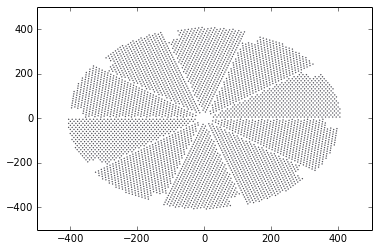

In [16]:
positioner_file = "../../surveyplan/data/pos_on_z1.txt"
positioner_data = loadtxt(positioner_file)
keep = where(positioner_data[:,8]==0)
keep = keep[0]
positioner_id  = positioner_data[keep,0]
x_pos = positioner_data[keep,1]
y_pos = positioner_data[keep,2]
z_pos = positioner_data[keep,3]
scatter(x_pos, y_pos, s=0.1)
n_pos = size(x_pos)
fiber_id = arange(n_pos)

patrol_radius = 6.0
inner_radius = 5.0 
fiber_radius = 1.0
print x_pos

## Create random set of targets

25400


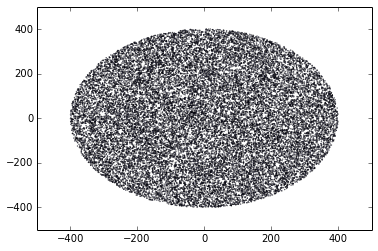

In [17]:
n_targets = n_pos * 5
print n_targets
target_id = arange(n_targets)
theta_rand = 2.0*pi*random.random(n_targets)
r_rand = 160000.0*random.random(n_targets)
x_target = sqrt(r_rand) * sin(theta_rand)
y_target = sqrt(r_rand) * cos(theta_rand)
ra = random.random(n_targets)*1.8
dec = random.random(n_targets)*1.2

scatter(x_target, y_target, s=0.1)

possible_types = ['ELG', 'LRG', 'QSO', 'STDSTAR', 'GAL', 'OTHER']
types = empty((0))
for i in range(n_targets):
    types = append(types, random.choice(possible_types))

## Run the simplest possible fiber assignment

In [29]:
x_design = zeros(n_pos)
y_design = zeros(n_pos)
ra_target = zeros(n_pos)
dec_target = zeros(n_pos)
num_targets = zeros(n_pos, dtype='int')
assigned_target = zeros(n_pos, dtype='int')
target_flag = ones(n_pos, dtype='int64')*256
type_assigned_target = empty((0))
target_available = zeros(n_targets) #bookkeeping variable, tells me if target is already assigned

all_available_targets = empty((0))

#loop on the positioners
for i in range(n_pos):
    x_pos_i = x_pos[i]
    y_pos_i = y_pos[i]
    distance = sqrt((x_target-x_pos_i)**2 + (y_target - y_pos_i)**2)
    
    # I get all possible targets within the reach of this positioner
    available = where(distance<patrol_radius) 
    # to append them in a single array listng all the possible targets
    all_available_targets = append(all_available_targets, available)
    # counting how many of those I have in each positioner..
    num_targets[i] = size(available[0])

    # Here I get the list of possible targets discarding those already assigned
    reachable = where((distance<patrol_radius)&(target_available==0)) 
    reachable = reachable[0]
    n_reachable = size(reachable)
    
    if (n_reachable):
        target = reachable[0]    
        target_available[target] = -1
        x_design[i] = x_target[target]
        y_design[i] = y_target[target]
        assigned_target[i] = target_id[target]
        type_assigned_target = append(type_assigned_target, types[target])
        ra_target[i] = ra[target]
        dec_target[i] = dec[target]
    else:
        x_design[i] = x_pos_i
        y_design[i] = y_pos_i
        ra_target[i] = -1.0
        dec_target[i] = 100.0
        assigned_target[i] = -1 
        type_assigned_target = append(type_assigned_target, 'SKY')

In [30]:
print num_targets, cumsum(num_targets)
print size(all_available_targets)
print type_assigned_target

[7 4 3 ..., 0 0 0] [    7    11    14 ..., 27961 27961 27961]
27961
['LRG' 'OTHER' 'QSO' ..., 'SKY' 'SKY' 'SKY']


In [34]:
tile_id = 1
hash_id = int(sum(target_id))
filename = "QuickFiber_%06d_%012d.fits"%(tile_id, hash_id)
print filename

c1=fits.Column(name='FIBER', format='I', array=fiber_id)
c2=fits.Column(name='POSITIONER', format='I', array=positioner_id)
c3=fits.Column(name='NUMTARGET', format='I', array=num_targets)
c4=fits.Column(name='OBJTYPE', format='8A', array=type_assigned_target)
c5=fits.Column(name='TARGETID',format='I',array=assigned_target)
c6=fits.Column(name='DESITARGET0',format='I',array=target_flag)
c7=fits.Column(name='RA',format='D',array=ra_target)
c8=fits.Column(name='DEC', format='D', array=dec_target)
c9=fits.Column(name='XFOCAL_DESIGN', format='D', array=x_design)
c10=fits.Column(name='YFOCAL_DESIGN', format='D', array=y_design)
c11=fits.Column(name='POTENTIALTARGETID', format='I', array=int_(all_available_targets))

fibermap=fits.ColDefs([c1,c2,c3,c4,c5,c6,c7,c8,c9,c10])
table_fibermap_hdu=fits.TableHDU.from_columns(fibermap)

potential_fibermap = fits.ColDefs([c11])
table_potential_fibermap_hdu=fits.TableHDU.from_columns(potential_fibermap)

hdu=fits.PrimaryHDU()
hdulist=fits.HDUList([hdu])
hdulist.append(table_fibermap_hdu)
hdulist.append(table_potential_fibermap_hdu)
hdulist.verify()

hdulist.writeto(filename)

QuickFiber_000001_000322567300.fits


In [35]:
hdu=fits.open(filename)
hdu.info()

Filename: QuickFiber_000001_000322567300.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       4   ()              
1                TableHDU        38   5080R x 10C   [I10, I10, I10, A8, I10, I10, D25.17, D25.17, D25.17, D25.17]   
2                TableHDU        11   27961R x 1C   [I10]   
